## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [543]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pprint import pprint

In [544]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

반복적으로 쓰는 함수툴

In [545]:
def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

def value_counts_ratio(df, col_name, target_name='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

def summarize_group(df, group_by_columns):
    """
    주어진 데이터프레임을 특정 열들로 그룹화하여 각 그룹의 '임신_성공_여부' 비율과 갯수를 요약하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_columns (list): 그룹화할 열 이름들의 리스트
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '임신 성공' 비율과 갯수 계산
        success_count = group['임신_성공_여부'].value_counts().get(1, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'임신_성공_여부' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

def plot_ratio(df, group_by_column, target_column='임신_성공_여부', success_value=1):
    """
    주어진 데이터프레임을 특정 열로 그룹화하여 각 그룹의 타겟 변수의 성공 비율을 시각화하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_column (str): 그룹화할 열 이름
    target_column (str): 타겟 변수 이름
    success_value (int): 타겟 변수의 성공을 나타내는 값
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '성공' 비율과 갯수 계산
        success_count = group[target_column].value_counts().get(success_value, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{success_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 임신 성공 여부 갯수와 총 갯수 표시
    for i, (success_count, total) in enumerate(zip(results_df[f"'{success_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{success_count} ({total})', ha='center', va='bottom', fontsize=8)
    
    # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{success_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{success_value} Ratio')
   
    # 그래프 출력
    plt.show()

def plot_ratio_boxplot(data, column_name, target_column='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열과 타겟 변수 간의 관계를 박스 플롯으로 시각화하는 함수.

    Parameters:
    data (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    target_column (str): 타겟 변수 이름
    """

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column_name, y=target_column, data=data)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{column_name} vs {target_column}')
    plt.xlabel(column_name)
    plt.ylabel(target_column)

    # 그래프 출력
    plt.show()

### Data Load

In [546]:
# 데이터 로드
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# 변수명에서 공백을 밑줄로 대체
train.columns = train.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace(' ', '_')

# 변경된 변수명 확인
print(train.columns)

Index(['ID', '시술_시기_코드', '시술_당시_나이', '임신_시도_또는_마지막_임신_경과_연수', '시술_유형',
       '특정_시술_유형', '배란_자극_여부', '배란_유도_유형', '단일_배아_이식_여부', '착상_전_유전_검사_사용_여부',
       '착상_전_유전_진단_사용_여부', '남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인',
       '여성_부_불임_원인', '부부_주_불임_원인', '부부_부_불임_원인', '불명확_불임_원인', '불임_원인_-_난관_질환',
       '불임_원인_-_남성_요인', '불임_원인_-_배란_장애', '불임_원인_-_여성_요인', '불임_원인_-_자궁경부_문제',
       '불임_원인_-_자궁내막증', '불임_원인_-_정자_농도', '불임_원인_-_정자_면역학적_요인',
       '불임_원인_-_정자_운동성', '불임_원인_-_정자_형태', '배아_생성_주요_이유', '총_시술_횟수',
       '클리닉_내_총_시술_횟수', 'IVF_시술_횟수', 'DI_시술_횟수', '총_임신_횟수', 'IVF_임신_횟수',
       'DI_임신_횟수', '총_출산_횟수', 'IVF_출산_횟수', 'DI_출산_횟수', '총_생성_배아_수',
       '미세주입된_난자_수', '미세주입에서_생성된_배아_수', '이식된_배아_수', '미세주입_배아_이식_수', '저장된_배아_수',
       '미세주입_후_저장된_배아_수', '해동된_배아_수', '해동_난자_수', '수집된_신선_난자_수', '저장된_신선_난자_수',
       '혼합된_난자_수', '파트너_정자와_혼합된_난자_수', '기증자_정자와_혼합된_난자_수', '난자_출처', '정자_출처',
       '난자_기증자_나이', '정자_기증자_나이', '동결_배아_사용_여부', '신선_배아_사용_여부', '기증_배아_사용_여부',
       '대리모_여부', 'PGD_시술_여부', 'PGS_시술_여부

In [547]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 69 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     256351 non-null  object 
 1   시술_시기_코드               256351 non-null  object 
 2   시술_당시_나이               256351 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  9370 non-null    float64
 4   시술_유형                  256351 non-null  object 
 5   특정_시술_유형               256349 non-null  object 
 6   배란_자극_여부               256351 non-null  int64  
 7   배란_유도_유형               256351 non-null  object 
 8   단일_배아_이식_여부            250060 non-null  float64
 9   착상_전_유전_검사_사용_여부       2718 non-null    float64
 10  착상_전_유전_진단_사용_여부       250060 non-null  float64
 11  남성_주_불임_원인             256351 non-null  int64  
 12  남성_부_불임_원인             256351 non-null  int64  
 13  여성_주_불임_원인             256351 non-null  int64  
 14  여성_부_불임_원인             256351 non-nu

In [548]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90067 entries, 0 to 90066
Data columns (total 68 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     90067 non-null  object 
 1   시술_시기_코드               90067 non-null  object 
 2   시술_당시_나이               90067 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  3297 non-null   float64
 4   시술_유형                  90067 non-null  object 
 5   특정_시술_유형               90067 non-null  object 
 6   배란_자극_여부               90067 non-null  int64  
 7   배란_유도_유형               90067 non-null  object 
 8   단일_배아_이식_여부            87891 non-null  float64
 9   착상_전_유전_검사_사용_여부       933 non-null    float64
 10  착상_전_유전_진단_사용_여부       87891 non-null  float64
 11  남성_주_불임_원인             90067 non-null  int64  
 12  남성_부_불임_원인             90067 non-null  int64  
 13  여성_주_불임_원인             90067 non-null  int64  
 14  여성_부_불임_원인             90067 non-null  int64  
 15  부부

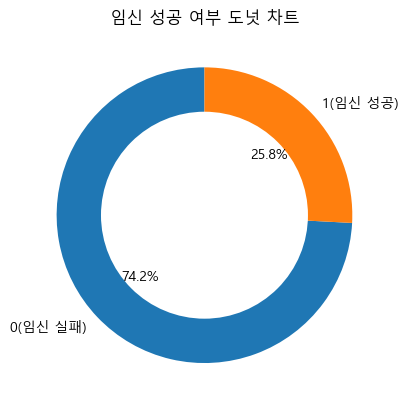

In [549]:
import matplotlib.pyplot as plt
import pandas as pd

# '임신_성공_여부' 변수의 값 개수 계산
value_counts = train['임신_성공_여부'].value_counts()

# 라벨 변경
labels = {1: '1(임신 성공)', 0: '0(임신 실패)'}
value_counts.index = value_counts.index.map(labels)

# 도넛 차트 그리기
fig, ax = plt.subplots()

# 파이 차트 그리기
wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# 도넛 차트 가운데에 원 그리기
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 차트 제목 설정
ax.set_title('임신 성공 여부 도넛 차트')

# 차트 표시
plt.show()

## EDA

### 1. 시술_시기_코드

난임 시술을 받은 시기를 기준으로 코드 부여

In [550]:
value_counts_ratio(train, '시술_시기_코드')


시술_시기_코드별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
TRCMWS    0.742583  0.257417  28285  9805  38090
TRDQAZ    0.754574  0.245426  29405  9564  38969
TRJXFG    0.733729  0.266271  26437  9594  36031
TRVNRY    0.740221  0.259779  26776  9397  36173
TRXQMD    0.743878  0.256122  25910  8921  34831
TRYBLT    0.730913  0.269087  26834  9879  36713
TRZKPL    0.744880  0.255120  26476  9068  35544


In [551]:
# # 원핫인코딩
# train = pd.get_dummies(train, columns=['시술_시기_코드'], prefix='시술_시기_코드')
# test = pd.get_dummies(test, columns=['시술_시기_코드'], prefix='시술_시기_코드')

### 2. 시술 당시 나이

환자의 시술 당시 나이(연령대)

In [552]:
value_counts_ratio(train, '시술_당시_나이')


시술_당시_나이별 임신_성공_여부 비율 및 갯수

                 0         1        0        1   Total
variable                                              
만18-34세   0.677378  0.322622  69415.0  33061.0  102476
만35-37세   0.721599  0.278401  41694.0  16086.0   57780
만38-39세   0.782862  0.217138  30725.0   8522.0   39247
만40-42세   0.840607  0.159393  31395.0   5953.0   37348
만43-44세   0.881988  0.118012  10807.0   1446.0   12253
만45-50세   0.832321  0.167679   5758.0   1160.0    6918
알 수 없음    1.000000  0.000000    329.0      0.0     329


In [553]:
# # '알 수 없음'인 행만 추출하여 새로운 데이터셋 생성
# unknown_age_dataset = train[train['시술_당시_나이'] == '알 수 없음']

In [554]:
test['시술_당시_나이'].value_counts()

만18-34세    36178
만35-37세    20211
만38-39세    13611
만40-42세    13266
만43-44세     4272
만45-50세     2413
알 수 없음       116
Name: 시술_당시_나이, dtype: int64

### 3. 임신 시도 또는 마지막 임신 경과 일수

환자가 처음 임신을 시도한 시점 또는 마지막 임신 이후 현재까지의 경과 연수 (년 단위)

In [555]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1    0    1  Total
variable                                     
0.0       0.666667  0.333333    8    4     12
1.0       0.666667  0.333333    4    2      6
2.0       0.809524  0.190476   17    4     21
3.0       0.752809  0.247191   67   22     89
4.0       0.757377  0.242623  231   74    305
5.0       0.754335  0.245665  522  170    692
6.0       0.750757  0.249243  744  247    991
7.0       0.764415  0.235585  928  286   1214
8.0       0.784864  0.215136  923  253   1176
9.0       0.795699  0.204301  814  209   1023
10.0      0.778247  0.221753  737  210    947
11.0      0.810271  0.189729  568  133    701
12.0      0.780392  0.219608  398  112    510
13.0      0.837838  0.162162  403   78    481
14.0      0.776435  0.223565  257   74    331
15.0      0.791339  0.208661  201   53    254
16.0      0.846535  0.153465  171   31    202
17.0      0.821429  0.178571  115   25    140
18.0      0.839623  0.160377   89   17

In [556]:
print("결측값 개수:", train['임신_시도_또는_마지막_임신_경과_연수'].isnull().sum())

train['임신_시도_또는_마지막_임신_경과_연수'].fillna(-1, inplace=True)
test['임신_시도_또는_마지막_임신_경과_연수'].fillna(-1, inplace=True)

print("결측값 개수:", train['임신_시도_또는_마지막_임신_경과_연수'].isnull().sum())

결측값 개수: 246981
결측값 개수: 0


In [557]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
-1.0      0.740073  0.259927  182784  64197  246981
 0.0      0.666667  0.333333       8      4      12
 1.0      0.666667  0.333333       4      2       6
 2.0      0.809524  0.190476      17      4      21
 3.0      0.752809  0.247191      67     22      89
 4.0      0.757377  0.242623     231     74     305
 5.0      0.754335  0.245665     522    170     692
 6.0      0.750757  0.249243     744    247     991
 7.0      0.764415  0.235585     928    286    1214
 8.0      0.784864  0.215136     923    253    1176
 9.0      0.795699  0.204301     814    209    1023
 10.0     0.778247  0.221753     737    210     947
 11.0     0.810271  0.189729     568    133     701
 12.0     0.780392  0.219608     398    112     510
 13.0     0.837838  0.162162     403     78     481
 14.0     0.776435  0.223565     257     74     331
 15.0     0.791339  0.

In [558]:
# dataset = train[train['임신_시도_또는_마지막_임신_경과_연수'] == -1.0]

### 4. 시술_유형

IVF 또는 DI 시술 여부

In [559]:
value_counts_ratio(train, '시술_유형')


시술_유형별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
DI        0.871086  0.128914    5480    811    6291
IVF       0.738395  0.261605  184643  65417  250060


In [560]:
test['시술_유형'].value_counts()

IVF    87891
DI      2176
Name: 시술_유형, dtype: int64

In [561]:
# 원핫인코딩
train = pd.get_dummies(train, columns=['시술_유형'], prefix='시술_유형')
test = pd.get_dummies(test, columns=['시술_유형'], prefix='시술_유형')

In [562]:
summarize_group(train, ['시술_유형_DI','시술_유형_IVF'])

Grouped by: 시술_유형_DI, 시술_유형_IVF

    group  '임신_성공_여부' count     ratio   Total
0  (0, 1)             65417  0.261605  250060
1  (1, 0)               811  0.128914    6291


### 5. 특정_시술_유형

IVF – 체외 수정 (시험관 아기 시술)  
ICSI – 세포질 내 정자 주입  
IUI – 인공 수정 (자궁 내 주입)  
ICI – 자궁경부 인공 수정  
GIFT – 생식세포 나팔관 이식  
FER – 냉동 배아 이식  
Generic DI – 기증 정자 주입  
IVI – 질 내 인공 수정   
BLASTOCYST – 배반포 단계에 이식  
AH – 배아를 hatching 시켜주는 과정  
Unknown – 시술 유형 정보가 제공되지 않았거나 알 수 없음  

(*) 특수 기호의 의미  
"/" – 복합적인 시술 방법을 의미 (예: ICSI / BLASTOCYST)  
":" – 동일 시술 내 세부 조합을 의미 (예: ICSI:IVF)  

In [563]:
summarize_group(train, ['특정_시술_유형'])

Grouped by: 특정_시술_유형

                                  group  '임신_성공_여부' count     ratio   Total
0                                   FER                 1  0.333333       3
1                                  GIFT                 0  0.000000       2
2                            Generic DI                12  0.169014      71
3                                   ICI                13  0.135417      96
4                                  ICSI             33385  0.272825  122368
5                             ICSI / AH               167  0.217165     769
6                     ICSI / AH:Unknown                 1  0.500000       2
7                    ICSI / BLASTOCYST                574  0.356743    1609
8               ICSI / BLASTOCYST :ICSI                 1  1.000000       1
9   ICSI / BLASTOCYST :IVF / BLASTOCYST                 1  0.250000       4
10   ICSI / BLASTOCYST:IVF / BLASTOCYST                 2  0.333333       6
11                            ICSI:ICSI                23  0.00993

In [564]:
test['특정_시술_유형'].value_counts()

ICSI                                  43237
IVF                                   32350
Unknown                                9216
IUI                                    2112
ICSI:ICSI                               797
ICSI / BLASTOCYST                       584
IVF:IVF                                 406
IVF / BLASTOCYST                        389
ICSI:IVF                                298
ICSI / AH                               264
IVF:ICSI                                133
IVF / AH                                105
ICSI:Unknown                             68
IVF:Unknown                              41
ICI                                      28
Generic DI                               26
IVI                                       8
ICSI / BLASTOCYST:IVF / BLASTOCYST        2
IUI:ICI                                   2
IVF:Unknown:Unknown:Unknown               1
Name: 특정_시술_유형, dtype: int64

In [565]:
# '특정_시술_유형' 변수의 값이 'FER' 또는 'GIFT'인 행 제거
train = train.loc[~train['특정_시술_유형'].isin(['FER', 'GIFT'])]
# test = test.loc[~test['특정_시술_유형'].isin(['FER', 'GIFT'])]

In [566]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# 시술 유형 수정 함수 정의
def clean_procedure(procedure):
    if isinstance(procedure, str):
        # 공백 제거
        procedure = procedure.replace(' ', '')
        # 시술 뒤에 Unknown이 붙어있으면 제거
        if ':Unknown' in procedure:
            procedure = procedure.replace(':Unknown', '')
    return procedure

# 시술 유형 수정
train['특정_시술_유형'] = train['특정_시술_유형'].apply(clean_procedure)
test['특정_시술_유형'] = test['특정_시술_유형'].apply(clean_procedure)

# 시술 유형 분리 및 원핫 인코딩 함수 정의
def process_procedures(df):
    # 시술 유형 분리 및 통일
    def split_and_unify(procedure):
        if isinstance(procedure, str):
            parts = procedure.split(':')
            unified_parts = []
            for part in parts:
                sub_parts = part.split('/')
                for sub_part in sub_parts:
                    if 'ICSI' in sub_part:
                        unified_parts.append('ICSI')
                    elif 'IVF' in sub_part:
                        unified_parts.append('IVF')
                    elif 'AH' in sub_part:
                        unified_parts.append('AH')
                    elif 'BLASTOCYST' in sub_part:
                        unified_parts.append('BLASTOCYST')
                    else:
                        unified_parts.append(sub_part)
            return unified_parts
        return []

    df_split = df['특정_시술_유형'].apply(split_and_unify)
    
    # MultiLabelBinarizer를 사용하여 원핫 인코딩
    mlb = MultiLabelBinarizer()
    reasons_encoded = mlb.fit_transform(df_split)
    reasons_df = pd.DataFrame(reasons_encoded, columns=[f'특정_시술_유형_{cls}' for cls in mlb.classes_])
    
    # '특정_시술_유형_Unknown' 변수 제거
    if '특정_시술_유형_Unknown' in reasons_df.columns:
        reasons_df = reasons_df.drop(columns=['특정_시술_유형_Unknown'])
    
    # 원래 데이터프레임과 병합
    df_encoded = df.drop(columns=['특정_시술_유형']).reset_index(drop=True)
    df_encoded = pd.concat([df_encoded, reasons_df], axis=1)
    
    return df_encoded

train = process_procedures(train)
test = process_procedures(test)

In [567]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256346 entries, 0 to 256345
Data columns (total 77 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     256346 non-null  object 
 1   시술_시기_코드               256346 non-null  object 
 2   시술_당시_나이               256346 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  256346 non-null  float64
 4   배란_자극_여부               256346 non-null  int64  
 5   배란_유도_유형               256346 non-null  object 
 6   단일_배아_이식_여부            250056 non-null  float64
 7   착상_전_유전_검사_사용_여부       2718 non-null    float64
 8   착상_전_유전_진단_사용_여부       250056 non-null  float64
 9   남성_주_불임_원인             256346 non-null  int64  
 10  남성_부_불임_원인             256346 non-null  int64  
 11  여성_주_불임_원인             256346 non-null  int64  
 12  여성_부_불임_원인             256346 non-null  int64  
 13  부부_주_불임_원인             256346 non-null  int64  
 14  부부_부_불임_원인             256346 non-nu

In [568]:
test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90067 entries, 0 to 90066
Data columns (total 76 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     90067 non-null  object 
 1   시술_시기_코드               90067 non-null  object 
 2   시술_당시_나이               90067 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  90067 non-null  float64
 4   배란_자극_여부               90067 non-null  int64  
 5   배란_유도_유형               90067 non-null  object 
 6   단일_배아_이식_여부            87891 non-null  float64
 7   착상_전_유전_검사_사용_여부       933 non-null    float64
 8   착상_전_유전_진단_사용_여부       87891 non-null  float64
 9   남성_주_불임_원인             90067 non-null  int64  
 10  남성_부_불임_원인             90067 non-null  int64  
 11  여성_주_불임_원인             90067 non-null  int64  
 12  여성_부_불임_원인             90067 non-null  int64  
 13  부부_주_불임_원인             90067 non-null  int64  
 14  부부_부_불임_원인             90067 non-null  int64  
 15  불명

### 6. 배란_자극_여부

배란 자극 치료가 사용되었는지 여부

In [569]:
value_counts_ratio(train, '배란_자극_여부')


배란_자극_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.768361  0.231639   45049  13581   58630
1         0.733729  0.266271  145070  52646  197716


### 7. 배란_유도_유형

사용된 배란 유도 방법 유형

In [570]:
value_counts_ratio(train, '배란_유도_유형')


배란_유도_유형별 임신_성공_여부 비율 및 갯수

                     0         1         0        1   Total
variable                                                   
기록되지 않은 시행    0.731588  0.268412  142242.0  52187.0  194429
생식선 자극 호르몬    0.000000  1.000000       0.0      1.0       1
세트로타이드 (억제제)  1.000000  0.000000       1.0      0.0       1
알 수 없음        0.773254  0.226746   47876.0  14039.0   61915


In [571]:
test['배란_유도_유형'].value_counts()

기록되지 않은 시행    68599
알 수 없음        21468
Name: 배란_유도_유형, dtype: int64

In [572]:
# test 데이터에 없는 값 제거
train = train.loc[~train['배란_유도_유형'].isin(['생식선 자극 호르몬', '세트로타이드 (억제제)'])]
test = test.loc[~test['배란_유도_유형'].isin(['생식선 자극 호르몬', '세트로타이드 (억제제)'])]

In [573]:
value_counts_ratio(train, '배란_유도_유형')


배란_유도_유형별 임신_성공_여부 비율 및 갯수

                   0         1       0      1   Total
variable                                             
기록되지 않은 시행  0.731588  0.268412  142242  52187  194429
알 수 없음      0.773254  0.226746   47876  14039   61915


### 8. 단일_배아_이식_여부

선택적으로 단일 배아를 이식했는지 여부

In [574]:
value_counts_ratio(train, '단일_배아_이식_여부')


단일_배아_이식_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.770572  0.229428  147697  43975  191672
1.0       0.632764  0.367236   36942  21440   58382


In [575]:
# 결측값 개수 확인
print("결측값 개수:", train['단일_배아_이식_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['단일_배아_이식_여부'].fillna(0, inplace=True)
test['단일_배아_이식_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['단일_배아_이식_여부'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


### 9. 착상_전_유전_검사_사용_여부

PGS(착상 전 유전 검사)가 시행되었는지 여부

In [576]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
1.0       0.851729  0.148271  2315  403   2718


In [577]:
# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['착상_전_유전_검사_사용_여부'].fillna(0, inplace=True)
test['착상_전_유전_검사_사용_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

결측값 개수: 253626
결측값 개수: 0


In [578]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.740472  0.259528  187803  65823  253626
1.0       0.851729  0.148271    2315    403    2718


### 10. 착상_전_유전_진단_사용_여부

PGD(착상 전 유전 진단)가 시행되었는지 여부

In [579]:
value_counts_ratio(train, '착상_전_유전_진단_사용_여부')


착상_전_유전_진단_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.737497  0.262503  182057  64801  246858
1.0       0.807885  0.192115    2582    614    3196


In [580]:
# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_진단_사용_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['착상_전_유전_진단_사용_여부'].fillna(0, inplace=True)
test['착상_전_유전_진단_사용_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_진단_사용_여부'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


In [581]:
summarize_group(train, ['착상_전_유전_진단_사용_여부', '착상_전_유전_검사_사용_여부'])

Grouped by: 착상_전_유전_진단_사용_여부, 착상_전_유전_검사_사용_여부

        group  '임신_성공_여부' count     ratio   Total
0  (0.0, 0.0)             65211  0.260369  250456
1  (0.0, 1.0)               401  0.148960    2692
2  (1.0, 0.0)               612  0.193060    3170
3  (1.0, 1.0)                 2  0.076923      26


### 11. 남성_주_불임_원인

남성의 주요 불임 원인 여부

In [582]:
value_counts_ratio(train, '남성_주_불임_원인')


남성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.740523  0.259477  184417  64619  249036
1         0.780104  0.219896    5701   1607    7308


### 12. 남성_부_불임_원인

남성의 부차적 불임 원인 여부

In [583]:
value_counts_ratio(train, '남성_부_불임_원인')


남성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.740843  0.259157  187420  65562  252982
1         0.802499  0.197501    2698    664    3362


In [584]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인

    group  '임신_성공_여부' count     ratio   Total
0  (0, 0)             63955  0.260321  245677
1  (0, 1)               664  0.197678    3359
2  (1, 0)              1607  0.219986    7305
3  (1, 1)                 0  0.000000       3


### 13. 여성_주_불임_원인

여성의 주요 불임 원인 여부

In [585]:
value_counts_ratio(train, '여성_주_불임_원인')


여성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.740407  0.259593  183969  64501  248470
1         0.780925  0.219075    6149   1725    7874


### 14. 여성_부_불임_원인

여성의 부차적 불임 원인 여부

In [586]:
value_counts_ratio(train, '여성_부_불임_원인')


여성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.740864  0.259136  187555  65602  253157
1         0.804205  0.195795    2563    624    3187


In [587]:
summarize_group(train, ['여성_주_불임_원인', '여성_부_불임_원인'])

Grouped by: 여성_주_불임_원인, 여성_부_불임_원인

    group  '임신_성공_여부' count     ratio   Total
0  (0, 0)             63879  0.260422  245290
1  (0, 1)               622  0.195597    3180
2  (1, 0)              1723  0.219016    7867
3  (1, 1)                 2  0.285714       7


In [588]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인', '여성_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인, 여성_주_불임_원인, 여성_부_불임_원인

           group  '임신_성공_여부' count     ratio   Total
0   (0, 0, 0, 0)             63866  0.260425  245238
1   (0, 0, 0, 1)                17  0.166667     102
2   (0, 0, 1, 0)                72  0.214925     335
3   (0, 0, 1, 1)                 0  0.000000       2
4   (0, 1, 0, 0)                 3  0.214286      14
5   (0, 1, 0, 1)               436  0.195779    2227
6   (0, 1, 1, 0)               224  0.200537    1117
7   (0, 1, 1, 1)                 1  1.000000       1
8   (1, 0, 0, 0)                10  0.263158      38
9   (1, 0, 0, 1)               169  0.198824     850
10  (1, 0, 1, 0)              1427  0.222482    6414
11  (1, 0, 1, 1)                 1  0.333333       3
12  (1, 1, 0, 1)                 0  0.000000       1
13  (1, 1, 1, 0)                 0  0.000000       1
14  (1, 1, 1, 1)                 0  0.000000       1


### 15. 부부_주_불임_원인

부부의 주요 불임 원인 여부

In [589]:
value_counts_ratio(train, '부부_주_불임_원인')


부부_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.740347  0.259653  183509  64360  247869
1         0.779823  0.220177    6609   1866    8475


### 16. 부부_부_불임_원인

부부의 부차적 불임 원인 여부

In [590]:
value_counts_ratio(train, '부부_부_불임_원인')


부부_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.741020  0.258980  188291  65806  254097
1         0.813084  0.186916    1827    420    2247


In [591]:
summarize_group(train, ['부부_주_불임_원인', '부부_부_불임_원인'])

Grouped by: 부부_주_불임_원인, 부부_부_불임_원인

    group  '임신_성공_여부' count     ratio   Total
0  (0, 0)             63940  0.260312  245628
1  (0, 1)               420  0.187416    2241
2  (1, 0)              1866  0.220333    8469
3  (1, 1)                 0  0.000000       6


In [592]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인'
                        , '여성_주_불임_원인', '여성_부_불임_원인'
                        , '부부_주_불임_원인', '부부_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인, 여성_주_불임_원인, 여성_부_불임_원인, 부부_주_불임_원인, 부부_부_불임_원인

                 group  '임신_성공_여부' count     ratio   Total
0   (0, 0, 0, 0, 0, 0)             63855  0.260416  245204
1   (0, 0, 0, 0, 0, 1)                 1  0.125000       8
2   (0, 0, 0, 0, 1, 0)                10  0.384615      26
3   (0, 0, 0, 1, 0, 0)                15  0.200000      75
4   (0, 0, 0, 1, 0, 1)                 1  0.050000      20
5   (0, 0, 0, 1, 1, 0)                 1  0.142857       7
6   (0, 0, 1, 0, 0, 0)                46  0.184000     250
7   (0, 0, 1, 0, 0, 1)                 1  0.500000       2
8   (0, 0, 1, 0, 1, 0)                25  0.301205      83
9   (0, 0, 1, 1, 1, 0)                 0  0.000000       2
10  (0, 1, 0, 0, 0, 0)                 0  0.000000       3
11  (0, 1, 0, 0, 0, 1)                 2  0.200000      10
12  (0, 1, 0, 0, 1, 0)                 1  1.000000       1
13  (0, 1, 0, 1, 0, 0)                 9  0.300000      30
14  (0, 1, 0, 1, 0, 1)         

### 17. 불명확_불임_원인

불명의 원인으로 인한 불임 여부

In [593]:
value_counts_ratio(train, '불명확_불임_원인')


불명확_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.742028  0.257972  142522  49549  192071
1         0.740529  0.259471   47596  16677   64273


In [594]:
# '불임_원인' 중 '남성' 관련 변수 리스트
infertility_cause_columns = [
    '남성_주_불임_원인',
    '남성_부_불임_원인'
]

# 더미 변수 생성
train['불임원인여부_남성관련'] = train[infertility_cause_columns].max(axis=1)
test['불임원인여부_남성관련'] = test[infertility_cause_columns].max(axis=1)

# 관련 변수 제거
# train = train.drop(columns=infertility_cause_columns)
# test = test.drop(columns=infertility_cause_columns)

In [595]:
# '불임_원인' 중 '여성' 관련 변수 리스트
infertility_cause_columns = [
    '여성_주_불임_원인',
    '여성_부_불임_원인'
]

# 더미 변수 생성
train['불임원인여부_여성관련'] = train[infertility_cause_columns].max(axis=1)
test['불임원인여부_여성관련'] = test[infertility_cause_columns].max(axis=1)

# 관련 변수 제거
# train = train.drop(columns=infertility_cause_columns)
# test = test.drop(columns=infertility_cause_columns)

In [596]:
# '불임_원인' 중 '부부' 관련 변수 리스트
infertility_cause_columns = [
    '부부_주_불임_원인',
    '부부_부_불임_원인'
]

# 더미 변수 생성
train['불임원인여부_부부관련'] = train[infertility_cause_columns].max(axis=1)
test['불임원인여부_부부관련'] = test[infertility_cause_columns].max(axis=1)

# 관련 변수 제거
# train = train.drop(columns=infertility_cause_columns)
# test = test.drop(columns=infertility_cause_columns)

In [597]:
# 변수명 변경
train = train.rename(columns={'불명확_불임_원인': '불임원인여부_불명확'})
test = test.rename(columns={'불명확_불임_원인': '불임원인여부_불명확'})

### 18. 불임_원인_-_난관_질환

난관 이상으로 인한 불임 여부

In [598]:
value_counts_ratio(train, '불임_원인_-_난관_질환')


불임_원인_-_난관_질환별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.741556  0.258444  163726  57061  220787
1         0.742245  0.257755   26392   9165   35557


### 19. 불임_원인_-_남성_요인

남성 요인으로 인한 불임 여부

In [599]:
value_counts_ratio(train, '불임_원인_-_남성_요인')


불임_원인_-_남성_요인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.754430  0.245570  121375  39508  160883
1         0.720116  0.279884   68743  26718   95461


### 20. 불임_원인_-_배란_장애

배란 장애로 인한 불임 여부

In [600]:
value_counts_ratio(train, '불임_원인_-_배란_장애')


불임_원인_-_배란_장애별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.745893  0.254107  166273  56645  222918
1         0.713367  0.286633   23845   9581   33426


### 21. 불임_원인_-_여성_요인

여성 요인으로 인한 불임 여부

In [601]:
value_counts_ratio(train, '불임_원인_-_여성_요인')


불임_원인_-_여성_요인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.741652  0.258348  190118  66226  256344


In [602]:
test['불임_원인_-_여성_요인'].value_counts()

0    90067
Name: 불임_원인_-_여성_요인, dtype: int64

In [603]:
# '불임_원인_-_여성_요인' 변수 제거
train = train.drop(columns=['불임_원인_-_여성_요인'])
test = test.drop(columns=['불임_원인_-_여성_요인'])

### 22. 불임_원인_-_자궁경부_문제

자궁경부 이상으로 인한 불임 여부

In [604]:
value_counts_ratio(train, '불임_원인_-_자궁경부_문제')


불임_원인_-_자궁경부_문제별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0         0.741642  0.258358  190108.0  66226.0  256334
1         1.000000  0.000000      10.0      0.0      10


### 23. 불임_원인_-_자궁내막증

자궁내막증으로 인한 불임 여부

In [605]:
value_counts_ratio(train, '불임_원인_-_자궁내막증')


불임_원인_-_자궁내막증별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.741382  0.258618  176480  61562  238042
1         0.745164  0.254836   13638   4664   18302


### 24. 불임_원인_-_정자_농도

파트너의 정자 농도 문제 여부

In [606]:
value_counts_ratio(train, '불임_원인_-_정자_농도')


불임_원인_-_정자_농도별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.741643  0.258357  189911  66157  256068
1         0.750000  0.250000     207     69     276


### 25. 불임_원인_-_정자_면역학적_요인

파트너의 정자 면역 관련 문제 여부

In [607]:
value_counts_ratio(train, '불임_원인_-_정자_면역학적_요인')


불임_원인_-_정자_면역학적_요인별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0         0.741651  0.258349  190117.0  66226.0  256343
1         1.000000  0.000000       1.0      0.0       1


In [608]:
test['불임_원인_-_정자_면역학적_요인'].value_counts()

0    90066
1        1
Name: 불임_원인_-_정자_면역학적_요인, dtype: int64

### 26. 불임_원인_-_정자_운동성

파트너의 정자 운동성 문제 여부

In [609]:
value_counts_ratio(train, '불임_원인_-_정자_운동성')


불임_원인_-_정자_운동성별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.741620  0.258380  190038  66209  256247
1         0.824742  0.175258      80     17      97


### 27. 불임_원인_-_정자_형태

파트너의 정자 형태 문제 여부

In [610]:
value_counts_ratio(train, '불임_원인_-_정자_형태')


불임_원인_-_정자_형태별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.741633  0.258367  190007  66194  256201
1         0.776224  0.223776     111     32     143


In [611]:
# '불임_원인' 중 '정자' 관련 변수 리스트
infertility_cause_columns = [
    '불임_원인_-_정자_농도',
    '불임_원인_-_정자_면역학적_요인',
    '불임_원인_-_정자_운동성',
    '불임_원인_-_정자_형태'
]

# 더미 변수 생성
train['불임이유_정자관련'] = train[infertility_cause_columns].max(axis=1)
test['불임이유_정자관련'] = test[infertility_cause_columns].max(axis=1)

# 관련 변수 제거
# train = train.drop(columns=infertility_cause_columns)
# test = test.drop(columns=infertility_cause_columns)

In [612]:
# '불임_원인' 중 '자궁' 관련 변수 리스트
infertility_cause_columns = [
    '불임_원인_-_난관_질환',
    '불임_원인_-_배란_장애',
    '불임_원인_-_자궁경부_문제',
    '불임_원인_-_자궁내막증'
]

# 더미 변수 생성
train['불임이유_자궁관련'] = train[infertility_cause_columns].max(axis=1)
test['불임이유_자궁관련'] = test[infertility_cause_columns].max(axis=1)

# 관련 변수 제거
# train = train.drop(columns=infertility_cause_columns)
# test = test.drop(columns=infertility_cause_columns)

In [613]:
# 변수명 변경
train = train.rename(columns={'불임_원인_-_남성_요인': '불임이유_남성요인'})
test = test.rename(columns={'불임_원인_-_남성_요인': '불임이유_남성요인'})

### 28. 배아_생성_주요_이유

배아 생성의 주된 목적(시술, 보관 등)

In [614]:
value_counts_ratio(train, '배아_생성_주요_이유')


배아_생성_주요_이유별 임신_성공_여부 비율 및 갯수

                            0         1         0        1   Total
variable                                                          
기증용                  1.000000  0.000000    1108.0      0.0    1108
기증용, 난자 저장용          1.000000  0.000000      44.0      0.0      44
기증용, 배아 저장용          1.000000  0.000000     125.0      0.0     125
기증용, 배아 저장용, 현재 시술용  0.650000  0.350000      13.0      7.0      20
기증용, 현재 시술용          0.620243  0.379757    2347.0   1437.0    3784
난자 저장용               1.000000  0.000000    1959.0      0.0    1959
난자 저장용, 배아 저장용       1.000000  0.000000       6.0      0.0       6
난자 저장용, 배아 저장용, 연구용  1.000000  0.000000       1.0      0.0       1
난자 저장용, 현재 시술용       0.800000  0.200000       4.0      1.0       5
배아 저장용               0.999130  0.000870    9183.0      8.0    9191
배아 저장용, 현재 시술용       0.734940  0.265060      61.0     22.0      83
연구용, 현재 시술용          1.000000  0.000000       1.0      0.0       1
현재 시술용               0.726433 

In [615]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# 배아_생성_주요_이유 분리 함수 정의
def split_reasons(reason):
    if isinstance(reason, str):
        return reason.split(', ')
    return []

# MultiLabelBinarizer를 사용하여 원핫 인코딩
def process_reasons(df):
    mlb = MultiLabelBinarizer()
    reasons = df['배아_생성_주요_이유'].apply(split_reasons)
    reasons_encoded = mlb.fit_transform(reasons)
    reasons_df = pd.DataFrame(reasons_encoded, columns=[f'배아_생성_주요_이유_{cls}' for cls in mlb.classes_])
    df = df.drop(columns=['배아_생성_주요_이유']).reset_index(drop=True)
    df_encoded = pd.concat([df, reasons_df], axis=1)
    
    # '배아_생성_주요_이유_연구용' 변수 제거
    if '배아_생성_주요_이유_연구용' in df_encoded.columns:
        df_encoded = df_encoded.drop(columns=['배아_생성_주요_이유_연구용'])
    
    return df_encoded

train = process_reasons(train)
test = process_reasons(test)

In [616]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256344 entries, 0 to 256343
Data columns (total 84 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     256344 non-null  object 
 1   시술_시기_코드               256344 non-null  object 
 2   시술_당시_나이               256344 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  256344 non-null  float64
 4   배란_자극_여부               256344 non-null  int64  
 5   배란_유도_유형               256344 non-null  object 
 6   단일_배아_이식_여부            256344 non-null  float64
 7   착상_전_유전_검사_사용_여부       256344 non-null  float64
 8   착상_전_유전_진단_사용_여부       256344 non-null  float64
 9   남성_주_불임_원인             256344 non-null  int64  
 10  남성_부_불임_원인             256344 non-null  int64  
 11  여성_주_불임_원인             256344 non-null  int64  
 12  여성_부_불임_원인             256344 non-null  int64  
 13  부부_주_불임_원인             256344 non-null  int64  
 14  부부_부_불임_원인             256344 non-nu

### 29. 총_시술_횟수

IVF 및 DI 포함한 전체 시술 횟수

In [617]:
value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0      1  Total
variable                                         
0회        0.709010  0.290990  69198  28400  97598
1회        0.750053  0.249947  42615  14201  56816
2회        0.755853  0.244147  29733   9604  39337
3회        0.763646  0.236354  18733   5798  24531
4회        0.772208  0.227792  11692   3449  15141
5회        0.784208  0.215792   7141   1965   9106
6회 이상     0.796670  0.203330  11006   2809  13815


### 30. 클리닉_내_총_시술_횟수

특정 클리닉에서 받은 IVF 및 DI 시술 횟수

In [618]:
value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0      1   Total
variable                                          
0회        0.717080  0.282920  87250  34424  121674
1회        0.754624  0.245376  45088  14661   59749
2회        0.762073  0.237927  26338   8223   34561
3회        0.767555  0.232445  14090   4267   18357
4회        0.778099  0.221901   7795   2223   10018
5회        0.792439  0.207561   4276   1120    5396
6회 이상     0.801487  0.198513   5281   1308    6589


### 31. IVF_시술_횟수

이전에 수행된 IVF 시술 횟수

In [619]:
value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0      1   Total
variable                                          
0회        0.713739  0.286261  74181  29752  103933
1회        0.749434  0.250566  43719  14617   58336
2회        0.754563  0.245437  29560   9615   39175
3회        0.764476  0.235524  17797   5483   23280
4회        0.772548  0.227452  10553   3107   13660
5회        0.787234  0.212766   6142   1660    7802
6회 이상     0.803898  0.196102   8166   1992   10158


### 32. DI_시술_횟수

이전에 수행된 DI 시술 횟수

In [620]:
value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0회        0.739349  0.260651  179261  63197  242458
1회        0.807877  0.192123    2359    561    2920
2회        0.782768  0.217232    2353    653    3006
3회        0.757702  0.242298    2361    755    3116
4회        0.779386  0.220614    1346    381    1727
5회        0.811823  0.188177     975    226    1201
6회 이상     0.763570  0.236430    1463    453    1916


### 33. 총_임신_횟수

IVF 및 DI 포함한 총 임신 횟수

In [621]:
value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0회        0.742547  0.257453  152534  52886  205420
1회        0.737092  0.262908   32306  11523   43829
2회        0.742075  0.257925    4635   1611    6246
3회        0.754692  0.245308     563    183     746
4회        0.782609  0.217391      72     20      92
5회        0.750000  0.250000       6      2       8
6회 이상     0.666667  0.333333       2      1       3


### 34. IVF_임신_횟수

IVF 시술로 인한 임신 횟수

In [622]:
value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.743151  0.256849  154788.0  53498.0  208286
1회        0.733592  0.266408   30458.0  11061.0   41519
2회        0.743953  0.256047    4306.0   1482.0    5788
3회        0.752640  0.247360     499.0    164.0     663
4회        0.762500  0.237500      61.0     19.0      80
5회        0.857143  0.142857       6.0      1.0       7
6회 이상     0.000000  1.000000       0.0      1.0       1


### 35. DI_임신_횟수

DI 시술로 인한 임신 횟수

In [623]:
value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.741152  0.258848  187730.0  65565.0  253295
1회        0.790857  0.209143    2076.0    549.0    2625
2회        0.725543  0.274457     267.0    101.0     368
3회        0.791667  0.208333      38.0     10.0      48
4회        1.000000  0.000000       5.0      0.0       5
5회        0.666667  0.333333       2.0      1.0       3


### 36. 총_출산_횟수

IVF 및 DI 시술로 출산한 횟수

In [624]:
value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.743151  0.256849  162415.0  56134.0  218549
1회        0.732753  0.267247   25916.0   9452.0   35368
2회        0.736842  0.263158    1652.0    590.0    2242
3회        0.721893  0.278107     122.0     47.0     169
4회        0.769231  0.230769      10.0      3.0      13
5회        1.000000  0.000000       1.0      0.0       1
6회 이상     1.000000  0.000000       2.0      0.0       2


### 37. IVF_출산_횟수

IVF 시술로 출산한 횟수

In [625]:
value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.743457  0.256543  164174.0  56651.0  220825
1회        0.730111  0.269889   24347.0   9000.0   33347
2회        0.737259  0.262741    1490.0    531.0    2021
3회        0.700730  0.299270      96.0     41.0     137
4회        0.769231  0.230769      10.0      3.0      13
5회        1.000000  0.000000       1.0      0.0       1


### 38. DI_출산_횟수

DI 시술로 출산한 횟수

In [626]:
value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.741384  0.258616  188313.0  65689.0  254002
1회        0.770814  0.229186    1648.0    490.0    2138
2회        0.765027  0.234973     140.0     43.0     183
3회        0.789474  0.210526      15.0      4.0      19
5회        1.000000  0.000000       2.0      0.0       2


In [627]:
# 숫자 매핑
mapping = {
    '0회': 0, '1회': 1, '2회': 2, '3회': 3, 
    '4회': 4, '5회': 5, '6회 이상': 6
}

# 변환할 열 목록
columns_to_map = [
    '총_시술_횟수', '클리닉_내_총_시술_횟수', 'IVF_시술_횟수', 
    'DI_시술_횟수', '총_임신_횟수', 'IVF_임신_횟수', 'DI_임신_횟수', 
    '총_출산_횟수', 'IVF_출산_횟수', 'DI_출산_횟수'
]

# 숫자로 변환
for col in columns_to_map:
    train[col] = train[col].map(mapping)
    test[col] = test[col].map(mapping)

In [628]:
# 비율 계산 (train 데이터프레임)
train['IVF_임신_시술_비율'] = np.where(train['IVF_시술_횟수'] > 0, train['IVF_임신_횟수'] / train['IVF_시술_횟수'], -1)
train['DI_임신_시술_비율'] = np.where(train['DI_시술_횟수'] > 0, train['DI_임신_횟수'] / train['DI_시술_횟수'], -1)
train['임신_성공률'] = np.where(train['총_시술_횟수'] > 0, train['총_임신_횟수'] / train['총_시술_횟수'], -1)

# 비율 계산 (test 데이터프레임)
test['IVF_임신_시술_비율'] = np.where(test['IVF_시술_횟수'] > 0, test['IVF_임신_횟수'] / test['IVF_시술_횟수'], -1)
test['DI_임신_시술_비율'] = np.where(test['DI_시술_횟수'] > 0, test['DI_임신_횟수'] / test['DI_시술_횟수'], -1)
test['임신_성공률'] = np.where(test['총_시술_횟수'] > 0, test['총_임신_횟수'] / test['총_시술_횟수'], -1)

### 39. 총_생성_배아_수

해당 시술에서 생성된 배아의 총 개수

In [629]:
value_counts_ratio(train, '총_생성_배아_수')


총_생성_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.828147  0.171853  44180.0  9168.0  53348
1.0       0.905137  0.094863  13778.0  1444.0  15222
2.0       0.819906  0.180094  15734.0  3456.0  19190
3.0       0.758150  0.241850  15884.0  5067.0  20951
4.0       0.722700  0.277300  15619.0  5993.0  21612
5.0       0.694547  0.305453  14175.0  6234.0  20409
6.0       0.677012  0.322988  12608.0  6015.0  18623
7.0       0.661676  0.338324  10606.0  5423.0  16029
8.0       0.649974  0.350026   8852.0  4767.0  13619
9.0       0.645674  0.354326   7187.0  3944.0  11131
10.0      0.639563  0.360437   5797.0  3267.0   9064
11.0      0.633145  0.366855   4489.0  2601.0   7090
12.0      0.647552  0.352448   3704.0  2016.0   5720
13.0      0.633881  0.366119   2739.0  1582.0   4321
14.0      0.644048  0.355952   2164.0  1196.0   3360
15.0      0.642289  0.357711   1616.0   900.0   2516
16.0      0.6529

In [630]:
print("결측값 개수:", train['총_생성_배아_수'].isnull().sum())

train['총_생성_배아_수'].fillna(-1, inplace=True)
test['총_생성_배아_수'].fillna(-1, inplace=True)

print("결측값 개수:", train['총_생성_배아_수'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


### 40. 미세주입된_난자_수

정자 미세주입(ICSI)으로 처리된 난자의 수

In [631]:
value_counts_ratio(train, '미세주입된_난자_수')


미세주입된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0        1   Total
variable                                              
0.0       0.749260  0.250740  95655.0  32011.0  127666
1.0       0.942681  0.057319   4276.0    260.0    4536
2.0       0.888783  0.111217   5594.0    700.0    6294
3.0       0.833418  0.166582   6594.0   1318.0    7912
4.0       0.789753  0.210247   7599.0   2023.0    9622
5.0       0.744609  0.255391   7907.0   2712.0   10619
6.0       0.723316  0.276684   8010.0   3064.0   11074
7.0       0.704831  0.295169   7338.0   3073.0   10411
8.0       0.693680  0.306320   6728.0   2971.0    9699
9.0       0.681734  0.318266   5867.0   2739.0    8606
10.0      0.665462  0.334538   5156.0   2592.0    7748
11.0      0.650375  0.349625   4245.0   2282.0    6527
12.0      0.660619  0.339381   3714.0   1908.0    5622
13.0      0.642012  0.357988   2986.0   1665.0    4651
14.0      0.661374  0.338626   2541.0   1301.0    3842
15.0      0.650893  0.349107   207

In [632]:
print("결측값 개수:", train['미세주입된_난자_수'].isnull().sum())

train['미세주입된_난자_수'].fillna(-1, inplace=True)
test['미세주입된_난자_수'].fillna(-1, inplace=True)

print("결측값 개수:", train['미세주입된_난자_수'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


### 41. 미세주입에서_생성된_배아_수

ICSI를 통해 생성된 배아의 수

In [633]:
value_counts_ratio(train, '미세주입에서_생성된_배아_수')


미세주입에서_생성된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0        1   Total
variable                                              
0.0       0.756900  0.243100  99736.0  32033.0  131769
1.0       0.908532  0.091468   9009.0    907.0    9916
2.0       0.817908  0.182092  10331.0   2300.0   12631
3.0       0.758276  0.241724  10468.0   3337.0   13805
4.0       0.719729  0.280271   9992.0   3891.0   13883
5.0       0.689546  0.310454   8911.0   4012.0   12923
6.0       0.671874  0.328126   7785.0   3802.0   11587
7.0       0.659416  0.340584   6275.0   3241.0    9516
8.0       0.651130  0.348870   5071.0   2717.0    7788
9.0       0.641665  0.358335   3961.0   2212.0    6173
10.0      0.635817  0.364183   3064.0   1755.0    4819
11.0      0.624231  0.375769   2334.0   1405.0    3739
12.0      0.662865  0.337135   1976.0   1005.0    2981
13.0      0.642027  0.357973   1381.0    770.0    2151
14.0      0.646536  0.353464   1092.0    597.0    1689
15.0      0.653974  0.346026 

In [634]:
print("결측값 개수:", train['미세주입에서_생성된_배아_수'].isnull().sum())

train['미세주입에서_생성된_배아_수'].fillna(-1, inplace=True)
test['미세주입에서_생성된_배아_수'].fillna(-1, inplace=True)

print("결측값 개수:", train['미세주입에서_생성된_배아_수'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


### 42. 이식된_배아_수

이식된 배아의 총 수

In [635]:
value_counts_ratio(train, '이식된_배아_수')


이식된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1      0      1   Total
variable                                          
0.0       0.999179  0.000821  36512     30   36542
1.0       0.686456  0.313544  64382  29407   93789
2.0       0.688911  0.311089  76361  34482  110843
3.0       0.831532  0.168468   7384   1496    8880


In [636]:
print("결측값 개수:", train['이식된_배아_수'].isnull().sum())

train['이식된_배아_수'].fillna(-1, inplace=True)
test['이식된_배아_수'].fillna(-1, inplace=True)

print("결측값 개수:", train['이식된_배아_수'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


### 43. 미세주입_배아_이식_수

ICSI 배아 중 이식된 배아의 수

In [637]:
value_counts_ratio(train, '미세주입_배아_이식_수')


미세주입_배아_이식_수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.776133  0.223867  107704  31066  138770
1.0       0.680559  0.319441   31629  14846   46475
2.0       0.687683  0.312317   41043  18640   59683
3.0       0.831643  0.168357    4263    863    5126


In [638]:
print("결측값 개수:", train['미세주입_배아_이식_수'].isnull().sum())

train['미세주입_배아_이식_수'].fillna(-1, inplace=True)
test['미세주입_배아_이식_수'].fillna(-1, inplace=True)

print("결측값 개수:", train['미세주입_배아_이식_수'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


### 44. 저장된_배아_수

환자를 위해 저장된 배아의 수

In [639]:
value_counts_ratio(train, '저장된_배아_수')


저장된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.777878  0.222122  129799.0  37064.0  166863
1.0       0.654653  0.345347   13332.0   7033.0   20365
2.0       0.629509  0.370491   12514.0   7365.0   19879
3.0       0.630304  0.369696    8511.0   4992.0   13503
4.0       0.639706  0.360294    5916.0   3332.0    9248
5.0       0.650552  0.349448    3889.0   2089.0    5978
6.0       0.667477  0.332523    2746.0   1368.0    4114
7.0       0.705461  0.294539    1873.0    782.0    2655
8.0       0.714971  0.285029    1342.0    535.0    1877
9.0       0.740482  0.259518     953.0    334.0    1287
10.0      0.781065  0.218935     792.0    222.0    1014
11.0      0.828076  0.171924     525.0    109.0     634
12.0      0.841121  0.158879     450.0     85.0     535
13.0      0.911616  0.088384     361.0     35.0     396
14.0      0.936232  0.063768     323.0     22.0     345
15.0      0.929134 

In [640]:
# '저장된_배아_수' 값이 17 이상이면 1을 부여하는 파생변수 생성
train['저장된_배아_수_17이상'] = train['저장된_배아_수'].apply(lambda x: 1 if x >= 17 else 0)
test['저장된_배아_수_17이상'] = test['저장된_배아_수'].apply(lambda x: 1 if x >= 17 else 0)

In [641]:
print("결측값 개수:", train['저장된_배아_수'].isnull().sum())

train['저장된_배아_수'].fillna(-1, inplace=True)
test['저장된_배아_수'].fillna(-1, inplace=True)

print("결측값 개수:", train['저장된_배아_수'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


### 45. 미세주입_후_저장된_배아_수

ICSI 처리된 배아 중 저장된 배아의 수

In [642]:
value_counts_ratio(train, '미세주입_후_저장된_배아_수')


미세주입_후_저장된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.755905  0.244095  154423.0  49866.0  204289
1.0       0.653485  0.346515    8064.0   4276.0   12340
2.0       0.624791  0.375209    7092.0   4259.0   11351
3.0       0.633647  0.366353    4708.0   2722.0    7430
4.0       0.645731  0.354269    3146.0   1726.0    4872
5.0       0.656188  0.343812    1983.0   1039.0    3022
6.0       0.673375  0.326625    1305.0    633.0    1938
7.0       0.741986  0.258014     949.0    330.0    1279
8.0       0.741419  0.258581     648.0    226.0     874
9.0       0.768233  0.231767     474.0    143.0     617
10.0      0.830835  0.169165     388.0     79.0     467
11.0      0.851724  0.148276     247.0     43.0     290
12.0      0.853282  0.146718     221.0     38.0     259
13.0      0.925000  0.075000     185.0     15.0     200
14.0      0.971429  0.028571     170.0      5.0     175
15.0      0.

In [643]:
# '미세주입_후_저장된_배아_수' 값이 14 이상이면 1을 부여하는 파생변수 생성
train['미세주입_후_저장된_배아_수_14이상'] = train['미세주입_후_저장된_배아_수'].apply(lambda x: 1 if x >= 14 else 0)
test['미세주입_후_저장된_배아_수_14이상'] = test['미세주입_후_저장된_배아_수'].apply(lambda x: 1 if x >= 14 else 0)

In [644]:
print("결측값 개수:", train['미세주입_후_저장된_배아_수'].isnull().sum())

train['미세주입_후_저장된_배아_수'].fillna(-1, inplace=True)
test['미세주입_후_저장된_배아_수'].fillna(-1, inplace=True)

print("결측값 개수:", train['미세주입_후_저장된_배아_수'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


### 46. 해동된_배아_수

동결 해동된 배아의 수

In [645]:
value_counts_ratio(train, '해동된_배아_수')


해동된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.732017  0.267983  153482.0  56188.0  209670
1.0       0.784757  0.215243   10245.0   2810.0   13055
2.0       0.761242  0.238758    9192.0   2883.0   12075
3.0       0.794957  0.205043    4288.0   1106.0    5394
4.0       0.778679  0.221321    2688.0    764.0    3452
5.0       0.766133  0.233867    1484.0    453.0    1937
6.0       0.752502  0.247498    1128.0    371.0    1499
7.0       0.759463  0.240537     622.0    197.0     819
8.0       0.699068  0.300932     525.0    226.0     751
9.0       0.672330  0.327670     277.0    135.0     412
10.0      0.741279  0.258721     255.0     89.0     344
11.0      0.756410  0.243590     118.0     38.0     156
12.0      0.673611  0.326389      97.0     47.0     144
13.0      0.679012  0.320988      55.0     26.0      81
14.0      0.720000  0.280000      54.0     21.0      75
15.0      0.714286 

In [646]:
print("결측값 개수:", train['해동된_배아_수'].isnull().sum())

train['해동된_배아_수'].fillna(-1, inplace=True)
test['해동된_배아_수'].fillna(-1, inplace=True)

print("결측값 개수:", train['해동된_배아_수'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


### 47. 해동_난자_수

동결 해동된 난자의 수

In [647]:
value_counts_ratio(train, '해동_난자_수')


해동_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.738167  0.261833  183515.0  65094.0  248609
1.0       0.923077  0.076923      24.0      2.0      26
2.0       0.907692  0.092308      59.0      6.0      65
3.0       0.907692  0.092308      59.0      6.0      65
4.0       0.892308  0.107692     116.0     14.0     130
5.0       0.859813  0.140187      92.0     15.0     107
6.0       0.801170  0.198830     137.0     34.0     171
7.0       0.713287  0.286713     102.0     41.0     143
8.0       0.703196  0.296804     154.0     65.0     219
9.0       0.780952  0.219048      82.0     23.0     105
10.0      0.769231  0.230769      70.0     21.0      91
11.0      0.761194  0.238806      51.0     16.0      67
12.0      0.657143  0.342857      46.0     24.0      70
13.0      0.812500  0.187500      26.0      6.0      32
14.0      0.613636  0.386364      27.0     17.0      44
15.0      0.594595  

In [648]:
print("결측값 개수:", train['해동_난자_수'].isnull().sum())

train['해동_난자_수'].fillna(-1, inplace=True)
test['해동_난자_수'].fillna(-1, inplace=True)

print("결측값 개수:", train['해동_난자_수'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


### 48. 수집된_신선_난자_수

신선 난자가 수집된 수

In [649]:
value_counts_ratio(train, '수집된_신선_난자_수')


수집된_신선_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0        1  Total
variable                                             
0.0       0.759528  0.240472  40896.0  12948.0  53844
1.0       0.948279  0.051721   4602.0    251.0   4853
2.0       0.909020  0.090980   5855.0    586.0   6441
3.0       0.867346  0.132654   7068.0   1081.0   8149
4.0       0.824000  0.176000   8240.0   1760.0  10000
5.0       0.790379  0.209621   9102.0   2414.0  11516
6.0       0.773797  0.226203   9763.0   2854.0  12617
7.0       0.746945  0.253055   9779.0   3313.0  13092
8.0       0.725173  0.274827   9668.0   3664.0  13332
9.0       0.718030  0.281970   9287.0   3647.0  12934
10.0      0.697813  0.302187   8902.0   3855.0  12757
11.0      0.682752  0.317248   8178.0   3800.0  11978
12.0      0.671998  0.328002   7353.0   3589.0  10942
13.0      0.664711  0.335289   6570.0   3314.0   9884
14.0      0.668292  0.331708   6032.0   2994.0   9026
15.0      0.662559  0.337441   5162.0   2629.0   7

In [650]:
print("결측값 개수:", train['수집된_신선_난자_수'].isnull().sum())

train['수집된_신선_난자_수'].fillna(-1, inplace=True)
test['수집된_신선_난자_수'].fillna(-1, inplace=True)

print("결측값 개수:", train['수집된_신선_난자_수'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


In [651]:
# '수집된_신선_난자_수' 변수의 값이 10 에서 24 이하인 경우 더미 변수로 1, 그렇지 않으면 0 부여
train['수집된_신선난자수_적정'] = train['수집된_신선_난자_수'].apply(lambda x: 1 if 10 <= x <= 24 else 0)
test['수집된_신선난자수_적정'] = test['수집된_신선_난자_수'].apply(lambda x: 1 if 10 <= x <= 24 else 0)

### 49. 저장된_신선_난자_수

저장된 신선 난자의 수

In [652]:
value_counts_ratio(train, '저장된_신선_난자_수')


저장된_신선_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.735751  0.264249  182016.0  65372.0  247388
1.0       0.972414  0.027586     141.0      4.0     145
2.0       0.989418  0.010582     187.0      2.0     189
3.0       0.985075  0.014925     198.0      3.0     201
4.0       0.980392  0.019608     200.0      4.0     204
5.0       0.972350  0.027650     211.0      6.0     217
6.0       0.981308  0.018692     210.0      4.0     214
7.0       0.977778  0.022222     176.0      4.0     180
8.0       0.994536  0.005464     182.0      1.0     183
9.0       0.979592  0.020408     144.0      3.0     147
10.0      0.993197  0.006803     146.0      1.0     147
11.0      0.967213  0.032787     118.0      4.0     122
12.0      0.982609  0.017391     113.0      2.0     115
13.0      1.000000  0.000000      86.0      0.0      86
14.0      0.977273  0.022727      86.0      2.0      88
15.0      0.9873

In [653]:
# '저장된_신선_난자_수' 변수의 값이 12 이상인 경우 더미 변수로 1 부여
train['저장된_신선난자수_초괴'] = train['저장된_신선_난자_수'].apply(lambda x: 1 if x >= 12 else 0)
test['저장된_신선난자수_초괴'] = test['저장된_신선_난자_수'].apply(lambda x: 1 if x >= 12 else 0)

In [654]:
print("결측값 개수:", train['저장된_신선_난자_수'].isnull().sum())

train['저장된_신선_난자_수'].fillna(-1, inplace=True)
test['저장된_신선_난자_수'].fillna(-1, inplace=True)

print("결측값 개수:", train['저장된_신선_난자_수'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


### 50. 혼합된_난자_수

정자와 혼합된 총 난자 수

In [655]:
value_counts_ratio(train, '혼합된_난자_수')


혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.803790  0.196210  37496.0  9153.0  46649
1.0       0.939370  0.060630   6058.0   391.0   6449
2.0       0.892197  0.107803   7970.0   963.0   8933
3.0       0.837625  0.162375   9270.0  1797.0  11067
4.0       0.794531  0.205469  10808.0  2795.0  13603
5.0       0.750419  0.249581  11639.0  3871.0  15510
6.0       0.735992  0.264008  12032.0  4316.0  16348
7.0       0.714706  0.285294  11416.0  4557.0  15973
8.0       0.698027  0.301973  10647.0  4606.0  15253
9.0       0.689592  0.310408   9726.0  4378.0  14104
10.0      0.672614  0.327386   8746.0  4257.0  13003
11.0      0.661431  0.338569   7664.0  3923.0  11587
12.0      0.661170  0.338830   6736.0  3452.0  10188
13.0      0.646627  0.353373   5636.0  3080.0   8716
14.0      0.659124  0.340876   4981.0  2576.0   7557
15.0      0.656989  0.343011   4277.0  2233.0   6510
16.0      0.64786

In [656]:
print("결측값 개수:", train['혼합된_난자_수'].isnull().sum())

train['혼합된_난자_수'].fillna(-1, inplace=True)
test['혼합된_난자_수'].fillna(-1, inplace=True)

print("결측값 개수:", train['혼합된_난자_수'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


### 51. 파트너_정자와_혼합된_난자_수

파트너 정자와 혼합된 난자의 수

In [657]:
value_counts_ratio(train, '파트너_정자와_혼합된_난자_수')


파트너_정자와_혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0        1  Total
variable                                             
0.0       0.782549  0.217451  49238.0  13682.0  62920
1.0       0.939346  0.060654   5374.0    347.0   5721
2.0       0.892287  0.107713   7207.0    870.0   8077
3.0       0.837771  0.162229   8464.0   1639.0  10103
4.0       0.796633  0.203367   9891.0   2525.0  12416
5.0       0.751072  0.248928  10687.0   3542.0  14229
6.0       0.737459  0.262541  11070.0   3941.0  15011
7.0       0.717054  0.282946  10545.0   4161.0  14706
8.0       0.698579  0.301421   9829.0   4241.0  14070
9.0       0.690976  0.309024   9020.0   4034.0  13054
10.0      0.674378  0.325622   8104.0   3913.0  12017
11.0      0.660474  0.339526   7075.0   3637.0  10712
12.0      0.661418  0.338582   6259.0   3204.0   9463
13.0      0.646854  0.353146   5202.0   2840.0   8042
14.0      0.659744  0.340256   4638.0   2392.0   7030
15.0      0.656934  0.343066   3960.0   2068.

In [658]:
print("결측값 개수:", train['파트너_정자와_혼합된_난자_수'].isnull().sum())

train['파트너_정자와_혼합된_난자_수'].fillna(-1, inplace=True)
test['파트너_정자와_혼합된_난자_수'].fillna(-1, inplace=True)

print("결측값 개수:", train['파트너_정자와_혼합된_난자_수'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


### 52. 기증자_정자와_혼합된_난자_수

기증자 정자와 혼합된 난자의 수

In [659]:
value_counts_ratio(train, '기증자_정자와_혼합된_난자_수')


기증자_정자와_혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.739554  0.260446  173455.0  61085.0  234540
1.0       0.937669  0.062331     692.0     46.0     738
2.0       0.887486  0.112514     773.0     98.0     871
3.0       0.835700  0.164300     824.0    162.0     986
4.0       0.770574  0.229426     927.0    276.0    1203
5.0       0.738497  0.261503     963.0    341.0    1304
6.0       0.715959  0.284041     978.0    388.0    1366
7.0       0.691083  0.308917     868.0    388.0    1256
8.0       0.692110  0.307890     807.0    359.0    1166
9.0       0.671952  0.328048     678.0    331.0    1009
10.0      0.647752  0.352248     605.0    329.0     934
11.0      0.667892  0.332108     545.0    271.0     816
12.0      0.653153  0.346847     435.0    231.0     666
13.0      0.636060  0.363940     381.0    218.0     599
14.0      0.645702  0.354298     308.0    169.0     477
15.0      0

In [660]:
print("결측값 개수:", train['기증자_정자와_혼합된_난자_수'].isnull().sum())

train['기증자_정자와_혼합된_난자_수'].fillna(-1, inplace=True)
test['기증자_정자와_혼합된_난자_수'].fillna(-1, inplace=True)

print("결측값 개수:", train['기증자_정자와_혼합된_난자_수'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


### 53. 난자_출처

난자 출처 정보

In [661]:
value_counts_ratio(train, '난자_출처')


난자_출처별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
기증 제공     0.684571  0.315429   10795   4974   15769
본인 제공     0.742019  0.257981  173844  60441  234285
알 수 없음    0.871065  0.128935    5479    811    6290


In [662]:
test['난자_출처'].value_counts()

본인 제공     82397
기증 제공      5494
알 수 없음     2176
Name: 난자_출처, dtype: int64

In [663]:
print("결측값 개수:", train['난자_출처'].isnull().sum())

train['난자_출처'].fillna(-1, inplace=True)
test['난자_출처'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_출처'].isnull().sum())

결측값 개수: 0
결측값 개수: 0


### 54. 정자_출처

정자 출처 정보

In [664]:
value_counts_ratio(train, '정자_출처')


정자_출처별 임신_성공_여부 비율 및 갯수

                    0         1         0        1   Total
variable                                                  
기증 제공        0.756247  0.243753   20430.0   6585.0   27015
미할당          0.893443  0.106557     109.0     13.0     122
배우자 및 기증 제공  1.000000  0.000000      14.0      0.0      14
배우자 제공       0.739835  0.260165  169565.0  59628.0  229193


In [665]:
test['정자_출처'].value_counts()

배우자 제공         80569
기증 제공           9460
미할당               33
배우자 및 기증 제공        5
Name: 정자_출처, dtype: int64

In [666]:
print("결측값 개수:", train['정자_출처'].isnull().sum())

train['정자_출처'].fillna(-1, inplace=True)
test['정자_출처'].fillna(-1, inplace=True)

print("결측값 개수:", train['정자_출처'].isnull().sum())

결측값 개수: 0
결측값 개수: 0


### 55. 난자_기증자_나이

난자 기증자의 등록 당시 나이

In [667]:
value_counts_ratio(train, '난자_기증자_나이')


난자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
만20세 이하   0.738095  0.261905     217     77     294
만21-25세   0.670094  0.329906    1564    770    2334
만26-30세   0.651728  0.348272    3243   1733    4976
만31-35세   0.694785  0.305215    4423   1943    6366
알 수 없음    0.745422  0.254578  180671  61703  242374


In [668]:
print("결측값 개수:", train['난자_기증자_나이'].isnull().sum())

train['난자_기증자_나이'].fillna(-1, inplace=True)
test['난자_기증자_나이'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_기증자_나이'].isnull().sum())

결측값 개수: 0
결측값 개수: 0


### 56. 정자_기증자_나이

정자 기증자의 등록 당시 나이

In [669]:
value_counts_ratio(train, '정자_기증자_나이')


정자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
만20세 이하   0.790066  0.209934     843    224    1067
만21-25세   0.758602  0.241398    4299   1368    5667
만26-30세   0.751878  0.248122    3803   1255    5058
만31-35세   0.751374  0.248626    3690   1221    4911
만36-40세   0.754260  0.245740    3984   1298    5282
만41-45세   0.756953  0.243047    2912    935    3847
알 수 없음    0.740035  0.259965  170587  59925  230512


### 57. 동결_배아_사용_여부

동결 배아가 사용되었는지 여부

In [670]:
value_counts_ratio(train, '동결_배아_사용_여부')


동결_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.732238  0.267762  153718  56211  209929
1.0       0.770617  0.229383   30921   9204   40125


In [671]:
print("결측값 개수:", train['동결_배아_사용_여부'].isnull().sum())

train['동결_배아_사용_여부'].fillna(0, inplace=True)
test['동결_배아_사용_여부'].fillna(0, inplace=True)

print("결측값 개수:", train['동결_배아_사용_여부'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


### 58. 신선_배아_사용_여부

신선 배아가 사용되었는지 여부

In [672]:
value_counts_ratio(train, '신선_배아_사용_여부')


신선_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.770433  0.229567   30758   9165   39923
1.0       0.732310  0.267690  153881  56250  210131


In [673]:
print("결측값 개수:", train['신선_배아_사용_여부'].isnull().sum())

train['신선_배아_사용_여부'].fillna(0, inplace=True)
test['신선_배아_사용_여부'].fillna(0, inplace=True)

print("결측값 개수:", train['신선_배아_사용_여부'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


### 59. 기증_배아_사용_여부

기증 배아가 사용되었는지 여부

In [674]:
value_counts_ratio(train, '기증_배아_사용_여부')


기증_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.739051  0.260949  182986  64610  247596
1.0       0.672498  0.327502    1653    805    2458


In [675]:
print("결측값 개수:", train['기증_배아_사용_여부'].isnull().sum())

train['기증_배아_사용_여부'].fillna(0, inplace=True)
test['기증_배아_사용_여부'].fillna(0, inplace=True)

print("결측값 개수:", train['기증_배아_사용_여부'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


In [676]:
summarize_group(train, ['신선_배아_사용_여부', '동결_배아_사용_여부', '기증_배아_사용_여부'])

Grouped by: 신선_배아_사용_여부, 동결_배아_사용_여부, 기증_배아_사용_여부

             group  '임신_성공_여부' count     ratio   Total
0  (0.0, 0.0, 0.0)               812  0.129032    6293
1  (0.0, 1.0, 0.0)              8916  0.229009   38933
2  (0.0, 1.0, 1.0)               248  0.251266     987
3  (1.0, 0.0, 0.0)             55653  0.266978  208455
4  (1.0, 0.0, 1.0)               557  0.378654    1471
5  (1.0, 1.0, 0.0)                40  0.195122     205


### 60. 대리모_여부

환자가 대리모로 활동했는지 여부

In [677]:
value_counts_ratio(train, '대리모_여부')


대리모_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.738511  0.261489  183893  65112  249005
1.0       0.711153  0.288847     746    303    1049


In [678]:
print("결측값 개수:", train['대리모_여부'].isnull().sum())

train['대리모_여부'].fillna(0, inplace=True)
test['대리모_여부'].fillna(0, inplace=True)

print("결측값 개수:", train['대리모_여부'].isnull().sum())

결측값 개수: 6290
결측값 개수: 0


### 61. PGD_시술_여부

해당 주기가 PGD 치료로 분류되는지 여부

In [679]:
value_counts_ratio(train, 'PGD_시술_여부')


PGD_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
1.0       0.720514  0.279486  1570  609   2179


In [680]:
train['PGD_시술_여부'].isnull().sum()

254165

In [681]:
# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGD_시술_여부'].fillna(0, inplace=True)
test['PGD_시술_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

결측값 개수: 254165
결측값 개수: 0


### 62. PGS_시술_여부

해당 주기가 PGS 치료로 분류되는지 여부

In [682]:
value_counts_ratio(train, 'PGS_시술_여부')


PGS_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
1.0       0.793675  0.206325  1531  398   1929


In [683]:
# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGS_시술_여부'].fillna(0, inplace=True)
test['PGS_시술_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

결측값 개수: 254415
결측값 개수: 0


In [684]:
summarize_group(train, ['PGD_시술_여부', 'PGS_시술_여부'])

Grouped by: PGD_시술_여부, PGS_시술_여부

        group  '임신_성공_여부' count     ratio   Total
0  (0.0, 0.0)             65219  0.258563  252236
1  (0.0, 1.0)               398  0.206325    1929
2  (1.0, 0.0)               609  0.279486    2179


### 63. 난자_채취_경과일

첫 시점으로부터 난자 채취까지 경과한 일수

In [685]:
value_counts_ratio(train, '난자_채취_경과일')


난자_채취_경과일별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.736184  0.263816  146396  52462  198858


In [686]:
print("결측값 개수:", train['난자_채취_경과일'].isnull().sum())

train['난자_채취_경과일'].fillna(-1, inplace=True)
test['난자_채취_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_채취_경과일'].isnull().sum())

결측값 개수: 57486
결측값 개수: 0


In [687]:
# '난자_채취_경과일' 변수의 값이 0 인 경우 더미 변수로 1 부여
train['난자채취_적정기간'] = train['난자_채취_경과일'].apply(lambda x: 1 if x == 0 else 0)
test['난자채취_적정기간'] = test['난자_채취_경과일'].apply(lambda x: 1 if x == 0 else 0)

### 64. 난자_해동_경과일

첫 시점으로부터 난자 해동까지 경과한 일수

In [688]:
value_counts_ratio(train, '난자_해동_경과일')


난자_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
0.0       0.777545  0.222455  1115.0  319.0   1434
1.0       1.000000  0.000000     2.0    0.0      2


In [689]:
train['난자_해동_경과일'].isnull().sum()

254908

In [690]:
print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

train['난자_해동_경과일'].fillna(-1, inplace=True)
test['난자_해동_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

결측값 개수: 254908
결측값 개수: 0


In [691]:
# '난자_혼합_경과일' 변수의 값이 0 인 경우 더미 변수로 1 부여
train['난자해동_적정기간'] = train['난자_해동_경과일'].apply(lambda x: 1 if x == 0 else 0)
test['난자해동_적정기간'] = test['난자_해동_경과일'].apply(lambda x: 1 if x == 0 else 0)

### 65. 난자_혼합_경과일

첫 시점으로부터 난자와 정자 혼합까지 경과한 일수

In [692]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.722924  0.277076  145970.0  55946.0  201916
1.0       0.846311  0.153689     413.0     75.0     488
2.0       0.754902  0.245098      77.0     25.0     102
3.0       0.720588  0.279412      49.0     19.0      68
4.0       0.600000  0.400000       3.0      2.0       5
5.0       0.791667  0.208333      19.0      5.0      24
6.0       1.000000  0.000000       8.0      0.0       8
7.0       1.000000  0.000000       1.0      0.0       1


In [693]:
train['난자_혼합_경과일'].isnull().sum()

53732

In [694]:
print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

train['난자_혼합_경과일'].fillna(-1, inplace=True)
test['난자_혼합_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

결측값 개수: 53732
결측값 개수: 0


In [695]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
-1.0      0.811025  0.188975   43578.0  10154.0   53732
 0.0      0.722924  0.277076  145970.0  55946.0  201916
 1.0      0.846311  0.153689     413.0     75.0     488
 2.0      0.754902  0.245098      77.0     25.0     102
 3.0      0.720588  0.279412      49.0     19.0      68
 4.0      0.600000  0.400000       3.0      2.0       5
 5.0      0.791667  0.208333      19.0      5.0      24
 6.0      1.000000  0.000000       8.0      0.0       8
 7.0      1.000000  0.000000       1.0      0.0       1


In [696]:
# '난자_혼합_경과일' 변수의 값이 0인 경우 더미 변수로 1, 값이 1이상인 경우 0으로 부여
train['난자혼합_적정기간'] = train['난자_혼합_경과일'].apply(lambda x: 1 if x == 0 else 0)
test['난자혼합_적정기간'] = test['난자_혼합_경과일'].apply(lambda x: 1 if x == 0 else 0)

### 66. 배아_이식_경과일

첫 시점으로부터 배아 이식까지 경과한 일수

In [697]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1      0      1  Total
variable                                         
0.0       0.748986  0.251014  18652   6251  24903
1.0       0.812985  0.187015   4921   1132   6053
2.0       0.787531  0.212469  27625   7453  35078
3.0       0.741243  0.258757  42935  14988  57923
4.0       0.655639  0.344361   2953   1551   4504
5.0       0.595546  0.404454  48512  32946  81458
6.0       0.699964  0.300036   1941    832   2773
7.0       0.588889  0.411111     53     37     90


In [698]:
print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

train['배아_이식_경과일'].fillna(-1, inplace=True)
test['배아_이식_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

결측값 개수: 43562
결측값 개수: 0


In [699]:
# '배아_이식_경과일' 변수의 값이 4에서 7 이하인 경우 더미 변수로 1, 그렇지 않으면 0 부여
train['배아이식_적정기간'] = train['배아_이식_경과일'].apply(lambda x: 1 if 4 <= x <= 7 else 0)
test['배아이식_적정기간'] = test['배아_이식_경과일'].apply(lambda x: 1 if 4 <= x <= 7 else 0)

### 67. 배아_해동_경과일

첫 시점으로부터 배아 해동까지 경과한 일수

In [700]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.770352  0.229648  30660.0  9140.0  39800
1.0       0.837838  0.162162     31.0     6.0     37
2.0       0.840659  0.159341    153.0    29.0    182
3.0       0.890244  0.109756    146.0    18.0    164
4.0       1.000000  0.000000     12.0     0.0     12
5.0       0.785714  0.214286    110.0    30.0    140
6.0       0.833333  0.166667     25.0     5.0     30
7.0       1.000000  0.000000      3.0     0.0      3


In [701]:
test['배아_해동_경과일'].value_counts()

0.0    13751
3.0       59
2.0       57
5.0       55
1.0       17
6.0        7
4.0        4
Name: 배아_해동_경과일, dtype: int64

In [702]:
print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

train['배아_해동_경과일'].fillna(-1, inplace=True)
test['배아_해동_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

결측값 개수: 215976
결측값 개수: 0


In [703]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
-1.0      0.736091  0.263909  158978.0  56998.0  215976
 0.0      0.770352  0.229648   30660.0   9140.0   39800
 1.0      0.837838  0.162162      31.0      6.0      37
 2.0      0.840659  0.159341     153.0     29.0     182
 3.0      0.890244  0.109756     146.0     18.0     164
 4.0      1.000000  0.000000      12.0      0.0      12
 5.0      0.785714  0.214286     110.0     30.0     140
 6.0      0.833333  0.166667      25.0      5.0      30
 7.0      1.000000  0.000000       3.0      0.0       3


In [704]:
# '배아_해동_경과일' 변수의 값이 0인 경우 더미 변수로 1 부여
train['배아해동_적정기간'] = train['배아_해동_경과일'].apply(lambda x: 1 if x == 0 else 0)
test['배아해동_적정기간'] = test['배아_해동_경과일'].apply(lambda x: 1 if x == 0 else 0)

In [705]:
# import pandas as pd

# # 파생 변수 생성 함수
# def create_features(df):
#     # 총 배아 생성 비율
#     df['ICSI_배아_생성_비율'] = df['총_생성_배아_수'] / df['미세주입된_난자_수']

#     # 미세주입 배아 이식 비율
#     df['ICSI_배아_이식_비율'] = df['미세주입_배아_이식_수'] / df['미세주입에서_생성된_배아_수']

#     # ICSI 성공률
#     df['ICSI_성공률'] = df['이식된_배아_수'] / df['미세주입에서_생성된_배아_수']
    
#     # 해동 배아 비율
#     df['해동_배아_비율'] = df['해동된_배아_수'] / df['저장된_배아_수']

#     # 총 배아 수 비율
#     df['총_배아_수'] = df['총_생성_배아_수'] + df['해동된_배아_수']
#     df['이식된_배아_수_비율'] = df['이식된_배아_수'] / df['총_배아_수']

#     # 저장된 배아 비율
#     df['저장된_배아_비율'] = df['저장된_배아_수'] / df['총_생성_배아_수']

#     # 정자와 혼합된 난자 비율 (기증자의 비율은 정반대값으로 동일하여 생략)
#     df['정자와_혼합된_난자_비율'] = df['파트너_정자와_혼합된_난자_수'] / df['혼합된_난자_수']
#     # df['기증자_정자와_혼합된_난자_비율'] = df['기증자_정자와_혼합된_난자_수'] / df['혼합된_난자_수']

#     # 사용된_신선_난자_수_비율
#     df['사용된_신선_난자_수'] = df['수집된_신선_난자_수'] - df['저장된_신선_난자_수']
#     df['사용된_신선_난자_수_비율'] = df['사용된_신선_난자_수'] / df['수집된_신선_난자_수']
#     df['사용된_난자_수'] = df['사용된_신선_난자_수'] + df['해동_난자_수']
#     df['혼합된_난자_수_비율'] = df['혼합된_난자_수'] / df['사용된_난자_수']
    
#     # 소수점 둘째 자리까지 반올림
#     df = df.round(2)
    
#     # inf, -inf, -3 값을 -1로 대체
#     df.replace([np.inf, -np.inf, -3], -1, inplace=True)

#     # 파생 변수를 생성하는 데 사용된 원래 변수 제거
#     drop_columns = [
#         '사용된_신선_난자_수', '사용된_난자_수'
#     ]
#     df.drop(columns=drop_columns, inplace=True)

#     # # 파생 변수를 생성하는 데 사용된 원래 변수 제거
#     # drop_columns = [
#     #     '총_생성_배아_수', '미세주입된_난자_수', '미세주입_배아_이식_수', '미세주입에서_생성된_배아_수',
#     #     '이식된_배아_수', '해동된_배아_수', '저장된_배아_수', '파트너_정자와_혼합된_난자_수',
#     #     '혼합된_난자_수', '수집된_신선_난자_수', '저장된_신선_난자_수', '해동_난자_수',
#     #     '사용된_신선_난자_수', '사용된_난자_수'

#     # ]
#     # df.drop(columns=drop_columns, inplace=True)
    
#     return df

# # 파생 변수 생성
# train = create_features(train)
# test = create_features(test)

### 68. 임신_성공_여부

해당 시술로부터 임신 성공 여부

In [706]:
value_counts_ratio(train, '임신_성공_여부')


임신_성공_여부별 임신_성공_여부 비율 및 갯수

            0    1         0        1   Total
variable                                     
0         1.0  0.0  190118.0      0.0  190118
1         0.0  1.0       0.0  66226.0   66226


## 변수 상태 확인

In [707]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256344 entries, 0 to 256343
Data columns (total 96 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     256344 non-null  object 
 1   시술_시기_코드               256344 non-null  object 
 2   시술_당시_나이               256344 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  256344 non-null  float64
 4   배란_자극_여부               256344 non-null  int64  
 5   배란_유도_유형               256344 non-null  object 
 6   단일_배아_이식_여부            256344 non-null  float64
 7   착상_전_유전_검사_사용_여부       256344 non-null  float64
 8   착상_전_유전_진단_사용_여부       256344 non-null  float64
 9   남성_주_불임_원인             256344 non-null  int64  
 10  남성_부_불임_원인             256344 non-null  int64  
 11  여성_주_불임_원인             256344 non-null  int64  
 12  여성_부_불임_원인             256344 non-null  int64  
 13  부부_주_불임_원인             256344 non-null  int64  
 14  부부_부_불임_원인             256344 non-nu

In [708]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90067 entries, 0 to 90066
Data columns (total 95 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     90067 non-null  object 
 1   시술_시기_코드               90067 non-null  object 
 2   시술_당시_나이               90067 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  90067 non-null  float64
 4   배란_자극_여부               90067 non-null  int64  
 5   배란_유도_유형               90067 non-null  object 
 6   단일_배아_이식_여부            90067 non-null  float64
 7   착상_전_유전_검사_사용_여부       90067 non-null  float64
 8   착상_전_유전_진단_사용_여부       90067 non-null  float64
 9   남성_주_불임_원인             90067 non-null  int64  
 10  남성_부_불임_원인             90067 non-null  int64  
 11  여성_주_불임_원인             90067 non-null  int64  
 12  여성_부_불임_원인             90067 non-null  int64  
 13  부부_주_불임_원인             90067 non-null  int64  
 14  부부_부_불임_원인             90067 non-null  int64  
 15  불임

In [709]:
# 두 데이터프레임의 변수명 확인
train_columns = set(train.columns)
test_columns = set(test.columns)

# train에만 있는 변수명
train_only_columns = train_columns - test_columns

# test에만 있는 변수명
test_only_columns = test_columns - train_columns

# 결과 출력
print("Train에만 있는 변수명:")
print(train_only_columns)

print("\nTest에만 있는 변수명:")
print(test_only_columns)

Train에만 있는 변수명:
{'임신_성공_여부'}

Test에만 있는 변수명:
set()


## 데이터 저장

In [710]:
# CSV 파일 저장
train.to_csv('../data/Total_train_dataset_34.csv', index=False, encoding='utf-8-sig')
test.to_csv('../data/Total_test_dataset_34.csv', index=False, encoding='utf-8-sig')

.